### TIP

- 상단에서 <런타임> 클릭 / 런타임 유형 변경 / GPU 선택  
- 코랩은 일정 시간이 지나면 런타임이 중단된다. 그러면 임시 저장된 학습되었던 것, 실행되었던 것 등이 사라진다. 이것을 방지하기 위해, "코랩 연결 끊김 방지"를 실행한다.  
  - F12 누름 / Console 창에서 아래 코드를 붙여 넣고 엔터:  
    -  function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)


## 0 유틸 도구  
  
- 코랩 폴더 내의 데이터 개수 확인 함수

In [ ]:
import cv2
from pathlib import Path
path=Path("/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data/tiger")
#path=path.glob("*.jpg")
images=[]
cnt = 0
for imagepath in path.glob('*.png'):
    cnt += 1

print(cnt)    

240


### 0.2 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.6 임포트

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.applications import ResNet50
from keras.applications import vgg19
from keras.applications import xception
from keras.applications import NASNetLarge
from keras.models import load_model
from keras import layers
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard as K

import io
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras.utils.vis_utils import plot_model
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


## Dataset


- target_size:   
  - (299,299) 사용은 inception V3 에서 최상단 레이어 연결하는 경우: include_top = True 인 경우  
  
  - (200,200) 사용은 False 인 경우에 사용. 다른 shape으로 바꿔 사용해도 됨

In [ ]:
train = ImageDataGenerator(rescale = 1/255,validation_split=0.3)

train_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data',
                                          target_size = (100,100),
                                          batch_size = 32,
                                          shuffle=True,
                                          class_mode='categorical',
                                          subset='training') 

val_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data',
                                          target_size = (100,100),
                                          batch_size = 32,
                                          shuffle=False,
                                          class_mode='categorical',
                                          subset='validation') 


Found 2199 images belonging to 11 classes.
Found 938 images belonging to 11 classes.


In [ ]:
val_dataset.class_indices

{'chicken': 0,
 'cow': 1,
 'dog': 2,
 'horse': 3,
 'monkey': 4,
 'mouse': 5,
 'pig': 6,
 'rabbit': 7,
 'sheep': 8,
 'snake': 9,
 'tiger': 10}

## Vanila CNN

In [ ]:
cnn = keras.models.Sequential([
                               keras.layers.Conv2D(64,7,activation='selu',padding="same",input_shape=[100,100,3]),
                               keras.layers.BatchNormalization(),
                               keras.layers.MaxPooling2D(2),

                               keras.layers.Conv2D(128,3,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.Conv2D(128,3,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.MaxPooling2D(2),

                               keras.layers.Conv2D(256,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),           
                               keras.layers.Conv2D(256,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.Conv2D(512,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),           
                               keras.layers.Conv2D(512,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.AveragePooling2D(2), 

                               keras.layers.Flatten(),
                               keras.layers.Dense(128,activation='selu'),
                               keras.layers.Dropout(0.3),
                               keras.layers.Dense(64,activation='selu'),
                               keras.layers.Dropout(0.3),
                               keras.layers.Dense(11,activation='softmax')

])

cnn.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함


In [ ]:
es = EarlyStopping(monitor='val_loss',patience=15,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

cnn_history = cnn.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 32,
                      epochs= 100,
                      callbacks=[es]) # 모델 학습

cnn.save('/content/drive/Shareddrives/dataset/test_cnn_0121_1.h5') # 모델 저장

32/32 [==============================] - 8s 235ms/step - loss: 0.1166 - accuracy: 0.9678 - val_loss: 2.3339 - val_accuracy: 0.6087


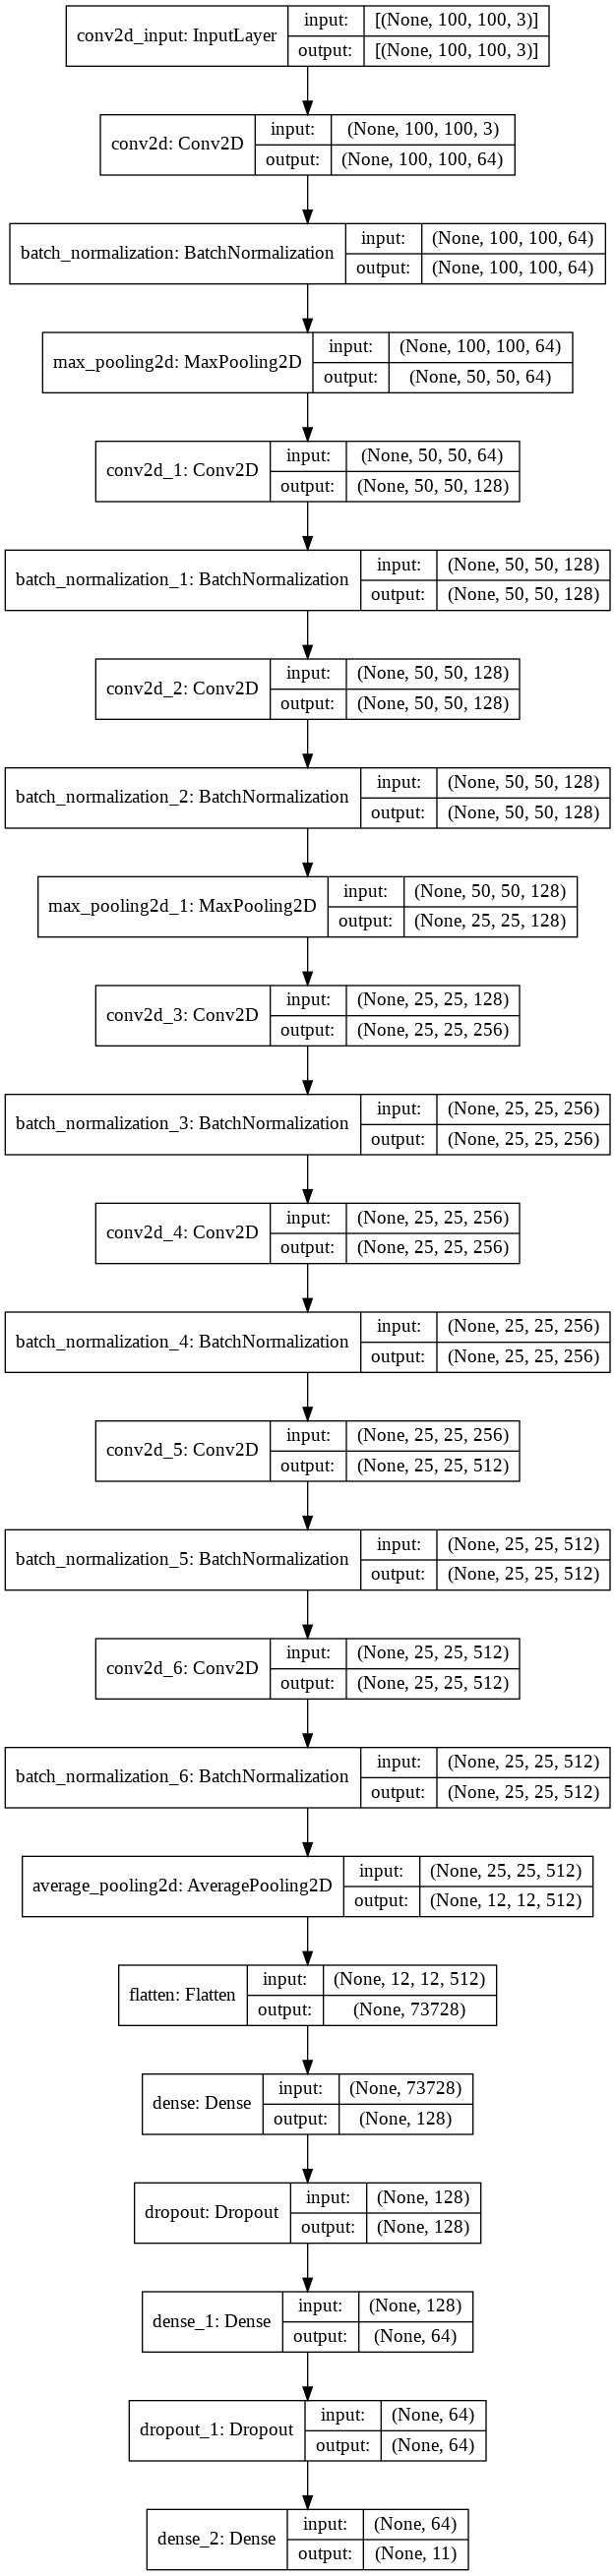

In [ ]:
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

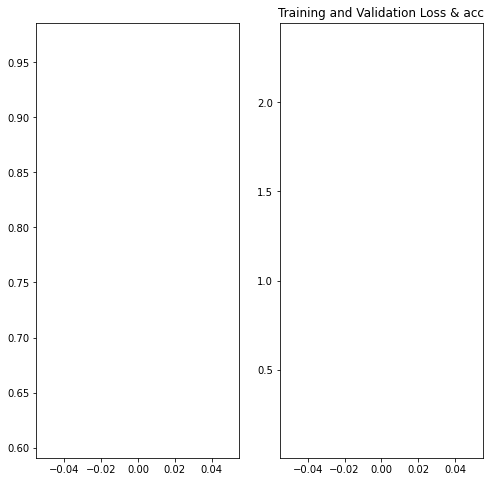

In [ ]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss= cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,val_acc, label='Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,val_loss, label='Loss')


plt.title('Training and Validation Loss & acc')
plt.show()

## Inception V3  
  
- 텐서플로우를 백엔드로 사용하는 고수준 언어 케라스에서 제공하는 API를 전이학습 모델로 사용: Inception V3  
  
- 최하단 레이어는 출력되는 클래스의 개수에 맞춰주면 된다  
  - 보통 다중 분류인 경우에 "활성화 함수"로 softmax를 사용  
  - 보통 이진 분류인 경우에, 이 함수를 sigmoid로 사용

In [ ]:
use_model = keras.models.load_model('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_1.h5')

In [ ]:
out = use_model.input
Inceptionv3 = InceptionV3(include_top=False,weights='imagenet',input_shape=(100,100,3))(out) # 구글에서 만든 우승 모델. 여러 모델 중 이번 task에서 가장 우수한 성능을 보이고, API로 제공되어 편리하게 사용할 수 있다.
#inputx = Inceptionv3.output # param num= 2048

flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
x = flatten_layer(Inceptionv3)
x = layers.Dropout(0.5)(keras.activations.elu(x)) 

prediction = keras.layers.Dense(11,activation='softmax')(x) # 최하단을 분류 개수에 맞추기. (예) 12 동물 분류인 경우에, Dense(12, activation='softmax')(x)

model =keras.Model(out, prediction)
#model =keras.Model(Inceptionv3.input, prediction)

model.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함


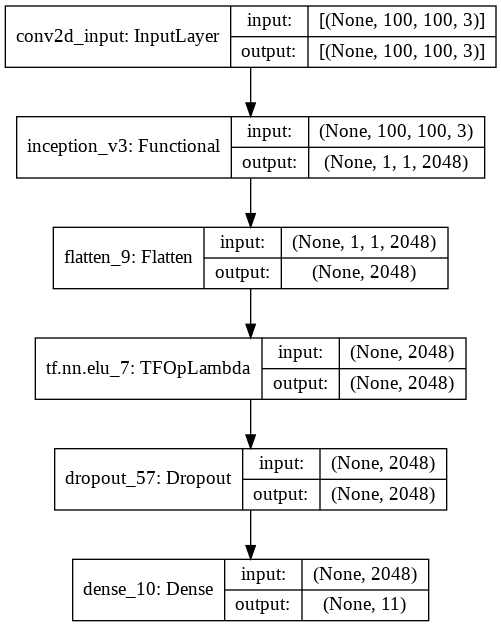

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
es = EarlyStopping(monitor='val_loss',patience=20,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

history = model.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 32,
                      epochs= 200,
                      callbacks=[es]) # 모델 학습

model.save('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_2.h5') # 모델 저장

Epoch 1/200
32/32 [==============================] - 14s 280ms/step - loss: 2.4939 - accuracy: 0.1512 - val_loss: 2.1758 - val_accuracy: 0.3188
Epoch 2/200
32/32 [==============================] - 7s 213ms/step - loss: 2.1632 - accuracy: 0.2608 - val_loss: 1.8468 - val_accuracy: 0.4414
Epoch 3/200
32/32 [==============================] - 7s 222ms/step - loss: 1.8573 - accuracy: 0.3780 - val_loss: 1.6151 - val_accuracy: 0.4861
Epoch 4/200
32/32 [==============================] - 8s 244ms/step - loss: 1.4688 - accuracy: 0.5502 - val_loss: 1.2650 - val_accuracy: 0.5991
Epoch 5/200
32/32 [==============================] - 7s 217ms/step - loss: 1.1102 - accuracy: 0.6491 - val_loss: 1.0843 - val_accuracy: 0.6546
Epoch 6/200
32/32 [==============================] - 7s 228ms/step - loss: 0.8191 - accuracy: 0.7394 - val_loss: 0.9310 - val_accuracy: 0.7281
Epoch 7/200
32/32 [==============================] - 7s 211ms/step - loss: 0.5970 - accuracy: 0.8419 - val_loss: 0.7922 - val_accuracy: 0.752

## 학습 과정 확인하기

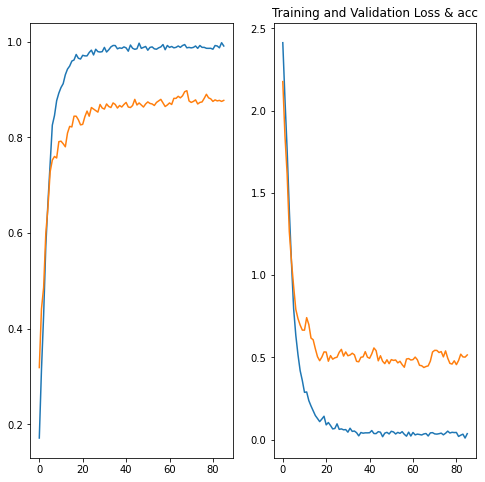

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,val_acc, label='Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,val_loss, label='Loss')


plt.title('Training and Validation Loss & acc')
plt.show()

## 실행

In [ ]:
def img_preprocess(img):
    img = img.convert('RGB').resize((100,100))
    img = np.array(img)

    img = img.reshape((100,100,3))
    plt.imshow(img)
    
    img= [img]
    img = np.array(img)
    img = img/255

    return img

In [ ]:
animal_class = {'chicken': 0,
 'cow': 1,
 'dog': 2,
 'horse': 3,
 'monkey': 4,
 'mouse': 5,
 'pig': 6,
 'rabbit': 7,
 'sheep': 8,
 'snake': 9,
 'tiger': 10}

In [ ]:
## load model
use_model = keras.models.load_model('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_2.h5')

In [ ]:
use_img = keras.preprocessing.image.load_img('/content/drive/Shareddrives/dataset/example/22 (10).jpg',target_size=(200,200))

## Predict

100.0 % monkey 상 입니다.

0.0 % dog 상 입니다.
0.0 % pig 상 입니다.
0.0 % rabbit 상 입니다.


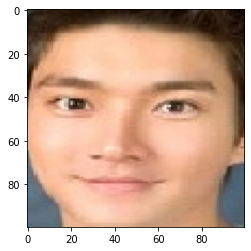

In [ ]:
use_img = keras.preprocessing.image.load_img('/content/drive/Shareddrives/dataset/example/22 (25).jpg',target_size=(100,100))

pred = use_model.predict(img_preprocess(use_img))
pred_i = np.argmax(pred)
#print(f'예측 점수:{pred},\n\n인덱스: {pred_i}\n\n')
for key, value in animal_class.items():
    if pred_i == value:
        print(round((np.max(pred)*100),2),'%',f'{key} 상 입니다.\n')
top3 = np.sort(pred[0])[::-1][1:4]

for s in top3:
    idx = list(pred[0]).index(s)
    for key,value in animal_class.items():
        if idx == value:
            print(round(s*100,2),'%',f'{key} 상 입니다.')

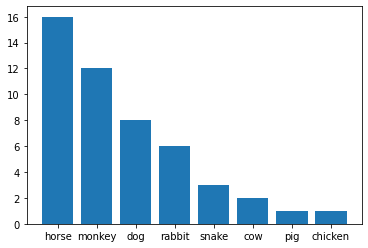

In [ ]:
monkey = 12
pig = 1
horse = 16
chicken = 1
#cow = 1
dog = 8
snake = 3
rabbit = 6
cow = 2


from matplotlib import pyplot as plt
values =  [16,12,8,6,3,2,1,1]
x = np.arange(8)

plt.bar(x, values)
plt.xticks(x,['horse','monkey','dog','rabbit','snake','cow','pig','chicken'])
plt.show()